# Setup for SAGA code

In [1]:
import os
import sys

working_dir = os.path.abspath('..')

In [2]:
# uncomment this to build the saga code instead of assuming it's installed in the current environment
# %cd ../../saga
# sagadir = !pwd
# sagadir = sagadir[0]
# !python setup.py build
#
# sagalibdir = os.path.join(sagadir, 'build/lib')
# print('Adding', sagalibdir, 'to the python path')
# sys.path.insert(0, sagalibdir)


%cd $working_dir

import os
os.environ['SAGA_DROPBOX']='/home/erik/Dropbox/SAGA/'
os.environ['SAGA_DIR']='/home/erik/projects/saga/'

/home/erik/projects/saga/erik


In [3]:
os.environ['SAGA_DROPBOX']='/home/erik/tmp/SAGA'

In [4]:
import SAGA as saga
saga.__version__

'0.28.4'

In [5]:
import numpy as np


%matplotlib inline
import matplotlib.pyplot as plt

Style consistency w/ yao

In [6]:
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['axes.labelsize'] = 'large'
plt.rcParams['legend.frameon'] = False
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['ytick.minor.size'] = 4

# Host sets

In [7]:
from easyquery import Query, QueryMaker

In [8]:
sagaqs = saga.QuickStart()
hosts_with_stats = sagaqs.host_catalog.load(include_stats=True)
#completed_hosts = Query("really_need_spec < 40").filter(hosts_with_stats)
#observed_hosts = Query("specs_ours > 10").filter(hosts_with_stats)

complete_host_query = sagaqs.host_catalog.construct_host_query("paper2_complete")
completed_hosts = complete_host_query.filter(hosts_with_stats)
observed_host_query = sagaqs.host_catalog.construct_host_query("paper2_observed")
observed_hosts = observed_host_query.filter(hosts_with_stats)

SAGA `shared_dir` set to /home/erik/tmp/SAGA
SAGA `local_dir`  set to /home/erik/projects/saga/


KeyError: 'specs_ours_rvir'

# Radial Distribution

In [9]:
def nfw(x, c=10):
    return (np.log1p(c*x) - c*x/(1.0+c*x)) / (np.log1p(c) - c/(1.0+c))
def cap_at_one(x):
    return np.where(x>1, 1, x)

## Yao's plot  

In [10]:
# needs saga version >= 0.14.1
from SAGA.database import FitsTable
from easyquery import Query, QueryMaker

In [11]:
saga.ObjectCuts.is_sat

In [12]:
sats = saga.ObjectCuts.is_sat.filter(sagaqs.object_catalog.load_clean_specs())
#sats_completed_hosts = QueryMaker.in1d("HOSTID", completed_hosts["HOSTID"]).filter(sats)

sats_completed_hosts = complete_host_query.filter(sats)
sats_observed_hosts = complete_host_query.filter(sats)

NameError: name 'complete_host_query' is not defined

In [ ]:
r_kpc = Query('Mr < -12.3').filter(sats_completed_hosts, 'RHOST_KPC')
r_kpc.sort()

In [ ]:
len(r_kpc)

In [ ]:
rbins = np.logspace(1, 2.5, 1000)

In [13]:
plt.semilogx(rbins, np.searchsorted(r_kpc, rbins)/len(r_kpc), label='SAGA ($M_r < -12.3$), 21 complete hosts', lw=2)
plt.semilogx(rbins, cap_at_one(nfw(rbins/300.0, 3)), label='NFW, $c=3$', ls='--')
plt.semilogx(rbins, cap_at_one(nfw(rbins/300.0, 10)), label='NFW, $c=10$', c='C1', ls='--', alpha=0.5)

plt.axvline(300.0, c='k', ls=':', lw=0.5)
plt.legend()
plt.xlabel('projected distance [kpc]')
plt.ylabel('Cumulative radial dist. (normalized)')
plt.tight_layout()

NameError: name 'rbins' is not defined

## Add LG Rfs

In [ ]:
from astropy import units as u
from astropy.coordinates import Galactocentric, CartesianRepresentation, SphericalRepresentation, ICRS, SkyCoord

In [ ]:
m31 = ICRS(10.68470833*u.deg, 41.26875*u.deg, distance=700*u.kpc)

In [23]:
mcconn_path = os.path.join(os.environ['HOME'], 'astrodata/mcconn12_nearbydwarfs')
sys.path.insert(1, mcconn_path)

import nearbygals
mcconn_tab = nearbygals.get_table(mcconn_path + '/NearbyGalaxies.dat')
mcconn_tab

ModuleNotFoundError: No module named 'nearbygals'

In [19]:
#exclude canis major
mcconn_tab = mcconn_tab[mcconn_tab['name']!='*Canis Major']


In [20]:
# V -> sdss is r      =    V - 0.46*(B-V) + 0.11 from http://www.sdss3.org/dr8/algorithms/sdssUBVRITransform.php

meanbmv = 1

mcconn_tab['rabs'] = mcconn_tab['Vabs'] - 0.46*meanbmv + .11

In [21]:
mcconn_mw = mcconn_tab[(mcconn_tab['distance'] < 300)&(mcconn_tab['rabs']<-12.3)&(mcconn_tab['name']!='Canis Major')]
mcconn_mw

name,center,EBmV,distmod,distmod+,distmod-,vh,vh+,vh-,Vmag,Vmag+,Vmag-,PA,PA+,PA-,e,e+,e-,muV0,muV0+,muV0-,rh,rh+,rh-,sigma_s,sigma_s+,sigma_s-,vrot_s,vrot_s+,vrot_s-,MHI,sigma_g,sigma_g+,sigma_g-,vrot_g,vrot_g+,vrot_g-,[Fe/H],[Fe/H]+,[Fe/H]-,F,References,Vabs,logLV,distance,distance+,distance-,rh_phys,radeg,decdeg,x,y,z,and_number,rabs
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,mag,solLum,kpc,kpc,kpc,kpc,deg,deg,kpc,kpc,kpc,,mag
bytes19,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,bytes40,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64
Sagittarius dSph,"<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc) (283.83125, -30.54527778, 26.30267992)>",0.153,17.1,0.15,0.15,140.0,2.0,2.0,3.6,0.3,0.3,102.0,2.0,2.0,0.64,0.02,0.02,25.2,0.3,0.3,342.0,12.0,12.0,11.4,0.7,0.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.4,0.2,0.2,1,(3)(4)(96)(97)(128)(129)(130)(177),-13.500000000000002,7.332000000000001,26.302679918953842,1.8169247606153085,1.8169247606153085,2.616689690098457,-76.16875000000005,-30.54527777777778,5.415400504704593,-21.99576548731745,-13.367524412527452,-99,-13.850000000000003
LMC,"<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc) (80.89375, -69.75611111, 50.5824662)>",0.926,18.52,0.09,0.09,262.2,3.4,3.4,0.4,0.1,0.1,999.9,99.9,99.9,9.99,9.99,9.99,99.9,9.9,9.9,99.99,9.99,9.99,20.2,0.5,0.5,49.8,15.9,15.9,460.0,15.8,0.2,0.2,63.0,3.0,3.0,-0.5,9.99,9.99,3,(16)(17)(41)(131)(132)(182),-18.12,9.180000000000001,50.58246620031137,2.0964677875148183,2.0964677875148183,1.4712371598604692,80.89375000000001,-69.75611111111111,2.770029759028174,17.281802071572912,-47.457898596532054,-99,-18.470000000000002
SMC,"<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc) (13.18666667, -72.82861111, 63.97348355)>",0.419,19.03,0.12,0.12,145.6,0.6,0.6,2.2,0.2,0.2,999.9,99.9,99.9,9.99,9.99,9.99,99.9,9.9,9.9,99.99,9.99,9.99,27.6,0.5,0.5,0.0,0.0,0.0,460.0,22.0,2.0,2.0,60.0,5.0,5.0,-1.0,0.02,0.02,3,(18)(19)(41)(133)(132)(184),-16.830000000000002,8.664000000000001,63.973483548264824,3.535305349563226,3.535305349563226,1.8607271118257618,13.186666666666667,-72.8286111111111,18.388943787368635,4.308573355467458,-61.121923557146516,-99,-17.180000000000003
Fornax,"<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc) (39.99708333, -34.44916667, 147.23125024)>",0.021,20.84,0.18,0.18,55.3,0.1,0.1,7.4,0.3,0.3,41.0,1.0,1.0,0.3,0.01,0.01,23.3,0.3,0.3,16.6,1.2,1.2,11.7,0.9,0.9,0.0,0.0,0.0,0.17,0.0,0.0,0.0,0.0,0.0,0.0,-0.99,0.01,0.01,2,(29)(26)(100)(136)(138)(130)(180),-13.44,7.308,147.23125024327194,12.204449353189222,12.204449353189222,0.7109420550718074,39.997083333333336,-34.44916666666666,93.01024666902455,78.0367956275823,-83.28501420389581,-99,-13.790000000000001
Leo I,"<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc) (152.11708333, 12.30638889, 253.51286305)>",0.036,22.02,0.13,0.13,282.5,0.1,0.1,10.0,0.3,0.3,79.0,3.0,3.0,0.21,0.03,0.03,22.6,0.3,0.3,3.4,0.3,0.3,9.2,1.4,1.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.43,0.01,0.01,2,(38)(39)(100)(130)(180),-12.02,6.74,253.51286304979072,15.177108422857918,15.177108422857918,0.2507292688613249,152.1170833333333,12.30638888888889,-218.93233269191234,115.83513960194594,54.03356241427603,-99,-12.370000000000001


In [22]:
#MC simulate a bunch of different viewing angles for different projected distances

def project_mc(coords, n, center=None, distance=40*u.Mpc, asangle=False):
    if center is None:
        frame = Galactocentric()
    else:
        frame = Galactocentric(galcen_coord=center, galcen_distance=center.distance)
        
    ccentered = coords.transform_to(frame)
    center = frame.realize_frame(CartesianRepresentation([0, 0, 0]*u.kpc))
    
    srep = SphericalRepresentation(lon=360*np.random.rand(n)*u.deg, 
                               lat=(np.arccos(2*np.random.rand(n)-1)-np.pi/2)*u.rad,
                               distance=distance)
    offset_coos = frame.realize_frame(ccentered.data + srep[:, np.newaxis])
    offset_center = frame.realize_frame(center.data + srep[:, np.newaxis])
    
    sep = offset_center.separation(offset_coos)
    if asangle:
        return sep
    else:
        return (sep*distance).to(u.kpc, u.dimensionless_angles())

### MW

<ipython-input-23-ce4fa3150ddc>:13: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/erik/miniconda3/envs/saga/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


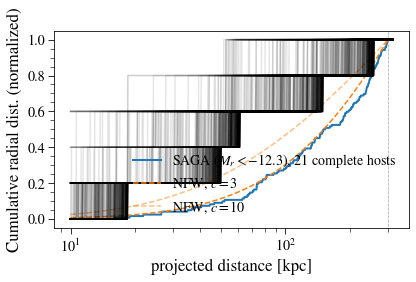

In [23]:
plt.semilogx(rbins, np.searchsorted(r_kpc, rbins)/len(r_kpc), label='SAGA ($M_r < -12.3$), 21 complete hosts', lw=2)
plt.semilogx(rbins, cap_at_one(nfw(rbins/300.0, 3)), label='NFW, $c=3$', ls='--')
plt.semilogx(rbins, cap_at_one(nfw(rbins/300.0, 10)), label='NFW, $c=10$', c='C1', ls='--', alpha=0.5)

mwprojs = project_mc(SkyCoord(mcconn_mw['center']), 400)
for proj in mwprojs:
    plt.semilogx(rbins, np.searchsorted(proj.to(u.kpc).value, rbins)/len(proj), label=None, alpha=.1, c='k')

plt.axvline(300.0, c='k', ls=':', lw=0.5)
plt.legend()
plt.xlabel('projected distance [kpc]')
plt.ylabel('Cumulative radial dist. (normalized)')
plt.tight_layout()

What if we have *no* distance cut?

In [24]:
mcconn_tab['name']

Sagittarius dSph
*Tucana III
*Draco II
Segue (I)
*Reticulum 2
*Cetus II
*Triangulum II
Ursa Major II
Bootes II
Segue II
Willman 1


(array([2., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 1., 1., 1., 0., 1., 2., 4., 1., 0., 0., 2., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 2., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
        0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
        0., 2., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1.]),
 array([  26.30267992,   55.68796702,   85.07325411,  114.45854121,
         143.8438283 ,  173.2291154 ,  202.6144025 ,  231.99968959,
         261.38497669,  290.77026378,  320.15555088,  349.54083798,
         378.92612507,  408.31141217,  437.69669926,  467.08198636,
         496.46727346,  525.85256055,  555.23784765,  584.62313474,
         614.00842184,  643.39370894,  672.77899603,  702.16428313,
         731.54957022,  760.93485732,  790.32014442,  819.70543151,
         849.09071861,  878.4760057 ,  907.8612928 ,  937.2465799 ,
      

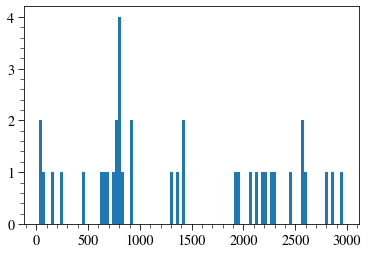

In [25]:
mcconn_nod = mcconn_tab[(mcconn_tab['rabs']<-12.3)&~np.in1d(mcconn_tab['name'].astype(str), ['Canis Major', 'Andromeda'])]
plt.hist(mcconn_nod['distance'], bins=100)

<ipython-input-26-fe2970573523>:15: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/erik/miniconda3/envs/saga/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


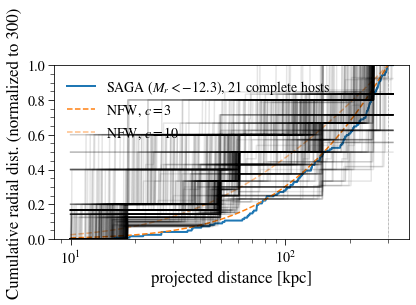

In [26]:
plt.semilogx(rbins, np.searchsorted(r_kpc, rbins)/len(r_kpc), label='SAGA ($M_r < -12.3$), 21 complete hosts', lw=2)
plt.semilogx(rbins, cap_at_one(nfw(rbins/300.0, 3)), label='NFW, $c=3$', ls='--')
plt.semilogx(rbins, cap_at_one(nfw(rbins/300.0, 10)), label='NFW, $c=10$', c='C1', ls='--', alpha=0.5)

mwprojs = project_mc(SkyCoord(mcconn_nod['center']), 400)
for proj in mwprojs:
    n_at_r = np.searchsorted(proj.to(u.kpc).value, rbins)
    plt.semilogx(rbins, n_at_r/np.sum(proj<300*u.kpc), label=None, alpha=.1, c='k')

plt.axvline(300.0, c='k', ls=':', lw=0.5)
plt.legend()
plt.xlabel('projected distance [kpc]')
plt.ylabel('Cumulative radial dist. (normalized to 300)')
plt.ylim(0, 1)
plt.tight_layout()

Lets make the figure a bit cleaner

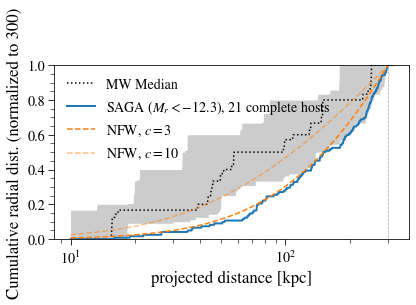

In [27]:
mwprojs = project_mc(SkyCoord(mcconn_nod['center']), 400)
percs_mw = []
nat300 = np.sum(mwprojs < 300*u.kpc, axis=1)
for r in rbins*u.kpc:
    n_distr_mv = np.sum(mwprojs < r, axis=1)/nat300
    percs_mw.append(np.percentile(n_distr_mv, [10, 50, 90]))
percs_mw = np.array(percs_mw)

plt.plot(rbins, percs_mw[:, 1], label='MW Median', c='k', ls=':')
plt.fill_between(rbins, percs_mw[:, 0], percs_mw[:, 2], color='k', alpha=.2, lw=0)
    

plt.semilogx(rbins, np.searchsorted(r_kpc, rbins)/len(r_kpc), label='SAGA ($M_r < -12.3$), 21 complete hosts', lw=2)
plt.semilogx(rbins, cap_at_one(nfw(rbins/300.0, 3)), label='NFW, $c=3$', ls='--')
plt.semilogx(rbins, cap_at_one(nfw(rbins/300.0, 10)), label='NFW, $c=10$', c='C1', ls='--', alpha=0.5)

plt.axvline(300.0, c='k', ls=':', lw=0.5)

plt.legend()
plt.xlabel('projected distance [kpc]')
plt.ylabel('Cumulative radial dist. (normalized to 300)')
plt.ylim(0, 1)
plt.tight_layout()

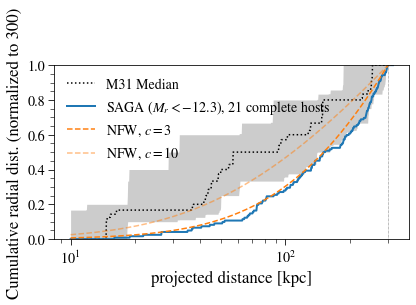

In [28]:
mwprojs = project_mc(SkyCoord(mcconn_nod['center']), 400)
percs = []
nat300 = np.sum(mwprojs < 300*u.kpc, axis=1)
for r in rbins*u.kpc:
    n_distr_mv = np.sum(mwprojs < r, axis=1)/nat300
    percs.append(np.percentile(n_distr_mv, [10, 50, 90]))
percs = np.array(percs)

plt.plot(rbins, percs[:, 1], label='M31 Median', c='k', ls=':')
plt.fill_between(rbins, percs[:, 0], percs[:, 2], color='k', alpha=.2, lw=0)
    

plt.semilogx(rbins, np.searchsorted(r_kpc, rbins)/len(r_kpc), label='SAGA ($M_r < -12.3$), 21 complete hosts', lw=2)
plt.semilogx(rbins, cap_at_one(nfw(rbins/300.0, 3)), label='NFW, $c=3$', ls='--')
plt.semilogx(rbins, cap_at_one(nfw(rbins/300.0, 10)), label='NFW, $c=10$', c='C1', ls='--', alpha=0.5)

plt.axvline(300.0, c='k', ls=':', lw=0.5)

plt.legend()
plt.xlabel('projected distance [kpc]')
plt.ylabel('Cumulative radial dist. (normalized to 300)')
plt.ylim(0, 1)
plt.tight_layout()

### M31 

In [29]:
m31coo = mcconn_tab[mcconn_tab['name'] == 'Andromeda']['center'][0]
m31coo

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    (10.68458333, 41.26916667, 783.42964277)>

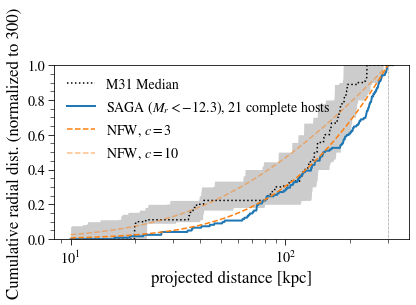

In [30]:
m31projs = project_mc(SkyCoord(mcconn_nod['center']), 400, center=m31coo)
percs_m31 = []
nat300 = np.sum(m31projs < 300*u.kpc, axis=1)
for r in rbins*u.kpc:
    n_distr_mv = np.sum(m31projs < r, axis=1)/nat300
    percs_m31.append(np.percentile(n_distr_mv, [10, 50, 90]))
percs_m31 = np.array(percs_m31)

plt.plot(rbins, percs_m31[:, 1], label='M31 Median', c='k', ls=':')
plt.fill_between(rbins, percs_m31[:, 0], percs_m31[:, 2], color='k', alpha=.2, lw=0)
    

plt.semilogx(rbins, np.searchsorted(r_kpc, rbins)/len(r_kpc), label='SAGA ($M_r < -12.3$), 21 complete hosts', lw=2)
plt.semilogx(rbins, cap_at_one(nfw(rbins/300.0, 3)), label='NFW, $c=3$', ls='--')
plt.semilogx(rbins, cap_at_one(nfw(rbins/300.0, 10)), label='NFW, $c=10$', c='C1', ls='--', alpha=0.5)

plt.axvline(300.0, c='k', ls=':', lw=0.5)

plt.legend()
plt.xlabel('projected distance [kpc]')
plt.ylabel('Cumulative radial dist. (normalized to 300)')
plt.ylim(0, 1)
plt.tight_layout()

### All together 

It's an entirely different kind of flying.

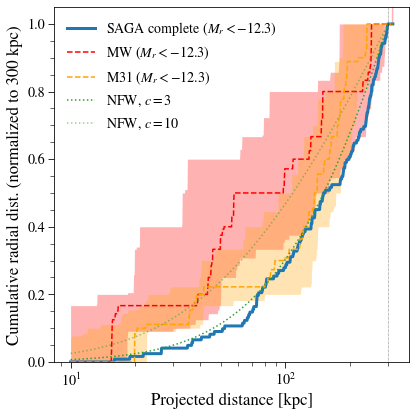

In [31]:
plt.figure(figsize=(6, 6))


plt.semilogx(rbins, np.searchsorted(r_kpc, rbins)/len(r_kpc), label='SAGA complete ($M_r < -12.3$)', lw=3,)

plt.plot(rbins, percs_mw[:, 1], label='MW ($M_r < -12.3$)', c='red', ls='--')
plt.fill_between(rbins, percs_mw[:, 0], percs_mw[:, 2], color='red', alpha=.3, lw=0)

plt.plot(rbins, percs_m31[:, 1], label='M31 ($M_r < -12.3$)', c='orange', ls='--')
plt.fill_between(rbins, percs_m31[:, 0], percs_m31[:, 2], color='orange', alpha=.3, lw=0)

plt.semilogx(rbins, cap_at_one(nfw(rbins/300.0, 3)), label='NFW, $c=3$', ls=':', c='C2')
plt.semilogx(rbins, cap_at_one(nfw(rbins/300.0, 10)), label='NFW, $c=10$', c='C2', ls=':', alpha=0.5)

plt.axvline(300.0, c='k', ls=':', lw=0.5)

plt.legend()
plt.xlabel('Projected distance [kpc]')
plt.ylabel('Cumulative radial dist. (normalized to 300 kpc)')
plt.ylim(0, 1.05)
plt.tight_layout()

#plt.savefig('../paperii/sat_radial.pdf')

## Two-panel version 

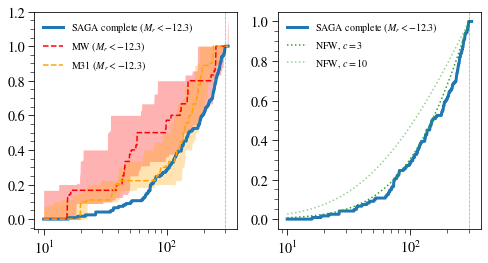

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

for ax in (ax1, ax2):
    ax.semilogx(rbins, np.searchsorted(r_kpc, rbins)/len(r_kpc), label='SAGA complete ($M_r < -12.3$)', lw=3,)

ax1.plot(rbins, percs_mw[:, 1], label='MW ($M_r < -12.3$)', c='red', ls='--')
ax1.fill_between(rbins, percs_mw[:, 0], percs_mw[:, 2], color='red', alpha=.3, lw=0)

ax1.plot(rbins, percs_m31[:, 1], label='M31 ($M_r < -12.3$)', c='orange', ls='--')
ax1.fill_between(rbins, percs_m31[:, 0], percs_m31[:, 2], color='orange', alpha=.3, lw=0)

ax2.semilogx(rbins, cap_at_one(nfw(rbins/300.0, 3)), label='NFW, $c=3$', ls=':', c='C2')
ax2.semilogx(rbins, cap_at_one(nfw(rbins/300.0, 10)), label='NFW, $c=10$', c='C2', ls=':', alpha=0.5)

for ax in (ax1, ax2):
    ax.axvline(300.0, c='k', ls=':', lw=0.5)

    ax.legend(fontsize=10)
# plt.xlabel('Projected distance [kpc]')
# plt.ylabel('Cumulative radial dist. (normalized to 300 kpc)')
# plt.ylim(0, 1.05)
# plt.tight_layout()

#plt.savefig('../paperii/sat_radial_.pdf')

## Two-figure version

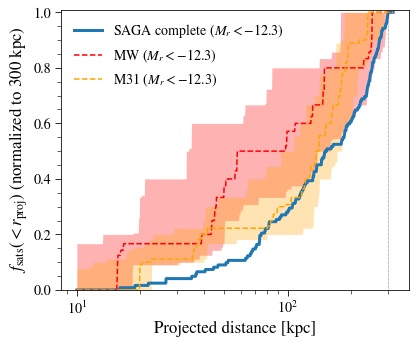

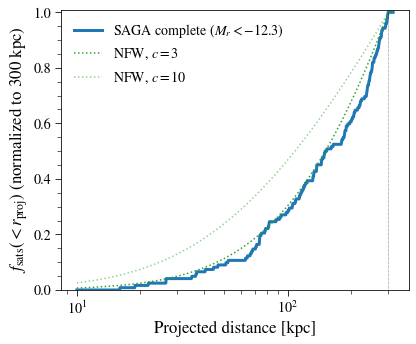

In [33]:
fig1, ax1 = plt.subplots(1, 1, figsize=(6, 5))
fig2, ax2 = plt.subplots(1, 1, figsize=(6, 5))


for ax in (ax1, ax2):
    ax.semilogx(rbins, np.searchsorted(r_kpc, rbins)/len(r_kpc), label='SAGA complete ($M_r < -12.3$)', lw=3,)

ax1.plot(rbins, percs_mw[:, 1], label='MW ($M_r < -12.3$)', c='red', ls='--')
ax1.fill_between(rbins, percs_mw[:, 0], percs_mw[:, 2], color='red', alpha=.3, lw=0)

ax1.plot(rbins, percs_m31[:, 1], label='M31 ($M_r < -12.3$)', c='orange', ls='--')
ax1.fill_between(rbins, percs_m31[:, 0], percs_m31[:, 2], color='orange', alpha=.3, lw=0)

ax2.semilogx(rbins, cap_at_one(nfw(rbins/300.0, 3)), label='NFW, $c=3$', ls=':', c='C2')
ax2.semilogx(rbins, cap_at_one(nfw(rbins/300.0, 10)), label='NFW, $c=10$', c='C2', ls=':', alpha=0.5)

for ax in (ax1, ax2):
    ax.axvline(300.0, c='k', ls=':', lw=0.5)

    ax.legend(fontsize=14)
    ax.set_xlabel('Projected distance [kpc]')
    ax.set_ylabel(r'$f_{\rm sats}(< r_{\rm proj})$ (normalized to 300 kpc)')
    ax.set_ylim(0, 1.01)
    
for fig in (fig1, fig2):
    fig.tight_layout()

#fig1.savefig('../paperii/figures/sat_radial_lg.pdf')
#fig2.savefig('../paperii/figures/sat_radial_nfw.pdf')

## LMC analog vs not 

In [34]:
sats = saga.ObjectCuts.is_sat.filter(sagaqs.object_catalog.load_clean_specs())
sats_completed_hosts = QueryMaker.in1d("HOSTID", completed_hosts["HOSTID"]).filter(sats)

Start with the most basic definition of an LMC analog we have uniform data for: Mr,sat - MK,host.

In [35]:
brightest_mrs = []
brightest_dmag = []
for host in sats_completed_hosts:
    itssats = sats[sats['HOSTID']==host['HOSTID']]
    brighti = np.argmin(itssats['Mr'])
    brightest_mrs.append(itssats[brighti]['Mr'])
    brightest_dmag.append(brightest_mrs[-1]-itssats[brighti]['HOST_MK'])
brightest_dmag = np.array(brightest_dmag)
brightest_dmag

array([ 7.429228  ,  7.66115878,  7.66115878,  7.66115878,  7.66115878,
        7.55523894,  7.55523894,  5.71321438,  5.71321438,  5.71321438,
        6.79241578,  6.79241578,  5.90419053,  5.90419053,  4.97968899,
        4.97968899,  4.97968899,  4.97968899,  4.97968899,  6.82377677,
        6.82377677,  6.82377677,  6.82377677,  7.97223057,  7.97223057,
        5.37203918,  5.37203918,  5.37203918,  5.37203918,  8.29089648,
        6.18637219,  6.18637219,  4.63099599,  4.63099599,  4.63099599,
        4.63099599, 11.38691761,  5.23734149,  5.23734149,  5.23734149,
        5.23734149,  4.60999361,  4.60999361,  3.74129757,  3.74129757,
        3.74129757,  3.74129757,  3.74129757,  3.74129757,  3.74129757,
        3.74129757,  5.05043826,  5.05043826,  5.05043826,  5.05043826,
        5.05043826,  5.05043826,  8.52776412,  8.52776412,  5.73628564,
        5.73628564,  5.73628564,  5.73628564,  5.73628564,  4.53105354,
        4.53105354,  4.53105354,  4.53105354,  4.53105354,  7.00

Text(0, 0.5, 'Cumulative radial dist. (normalized to 300 kpc)')

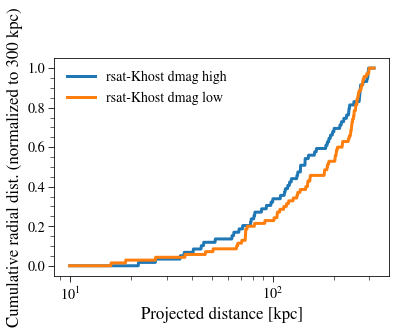

In [36]:
thresh = 5
#r_kpc_above = Query('Mr < -12.3').filter(sats_completed_hosts, 'RHOST_KPC'thresh
r_kpc_above = sats_completed_hosts[brightest_dmag<thresh]['RHOST_KPC']
r_kpc_above.sort()

r_kpc_below = sats_completed_hosts[brightest_dmag>thresh]['RHOST_KPC']
r_kpc_below.sort()

plt.semilogx(rbins, np.searchsorted(r_kpc_above, rbins)/len(r_kpc_above), label='rsat-Khost dmag high', lw=3)
plt.semilogx(rbins, np.searchsorted(r_kpc_below, rbins)/len(r_kpc_below), label='rsat-Khost dmag low', lw=3)
plt.legend(loc=0)
plt.xlabel('Projected distance [kpc]')
plt.ylabel('Cumulative radial dist. (normalized to 300 kpc)')
#plt.savefig('/home/erik/win_home/Desktop/lmc_like_radialdist.pdf')

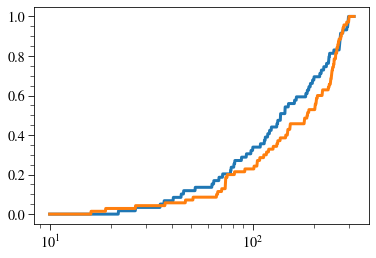

In [37]:
plt.semilogx(rbins, np.searchsorted(r_kpc_above, rbins)/len(r_kpc_above), label='SAGA complete ($M_r < -12.3$)', lw=3,)
plt.semilogx(rbins, np.searchsorted(r_kpc_below, rbins)/len(r_kpc_below), label='SAGA complete ($M_r < -12.3$)', lw=3,)

Follow the paper ii definition of LMC is anything with Mr < -18.3

In [38]:
hostsids_w_lmc = []
for hostid in np.unique(sats_completed_hosts['HOSTID']):
    itssats = sats[sats['HOSTID']==hostid]
    has_lmc = np.any(itssats['Mr']<-18.3)
    if has_lmc:
        hostsids_w_lmc.append(hostid)
        
hostsids_w_lmc = np.array(hostsids_w_lmc)
        
sat_in_lmc_system = np.in1d(sats_completed_hosts['HOSTID'], hostsids_w_lmc)
sats_with_lmcs = sats_completed_hosts[sat_in_lmc_system]
sats_with_no_lmcs = sats_completed_hosts[~sat_in_lmc_system]

# Un-normed + normed version

In [39]:
#build per-host radial distributions
r_kpc_hosts = {}
for hostid in observed_hosts['HOSTID']:
    sat_qry = (Query('Mr < -12.3') & QueryMaker.equals('HOSTID', hostid))
    r_kpc_hosts[hostid] = np.array(sat_qry.filter(sats_completed_hosts, 'RHOST_KPC'), dtype=float)*u.kpc

In [40]:
# binned quantities
def binr(rbins, all_rs):
    n_in_rbin = []
    for r in rbins:
        n_in_rbin.append(np.sum(all_rs<r))
    return np.array(n_in_rbin)
    
n_in_rbin = binr(rbins, Query('Mr < -12.3').filter(sats_completed_hosts, 'RHOST_KPC'))
n_in_rbin_lmc = binr(rbins, Query('Mr < -12.3').filter(sats_with_lmcs, 'RHOST_KPC'))
n_in_rbin_nlmc = binr(rbins, Query('Mr < -12.3').filter(sats_with_no_lmcs, 'RHOST_KPC'))

In [90]:
mcconn_tab_saga_observable = mcconn_tab[(mcconn_tab['rabs']<-12.3)&(mcconn_tab['name']!='Canis Major')]

In [108]:
def get_rbin_percs(projs, rbins, norm=None, percs=[10, 50, 90]):
    
    res = []
    if norm is None:
        normfactor = 1
    else:
        normfactor = np.sum(projs < norm, axis=1)
        
    for r in rbins:
        res.append(np.percentile(np.sum(projs < r, axis=1)/normfactor, percs))

    return np.array(res)

In [ ]:
def r_to_steps(r, upper=1000):
    r_step = np.concatenate([[0]*u.kpc, r, [upper]*u.kpc])
    n = np.concatenate([[], np.arange(len(r)), [len(r), len(r)]])
    return r_step, n

## Apply a "within MW" or "within M31" (400 kpc) cut

In [140]:
#MW 
mcconn_mw = mcconn_tab_saga_observable[(mcconn_tab_saga_observable['distance'] < 300)]
mwprojs_shrunk = project_mc(SkyCoord(mcconn_mw['center']), 1000)

percs_mw_unnorm = get_rbin_percs(mwprojs_shrunk, rbins*u.kpc, None)
percs_mw_norm = get_rbin_percs(mwprojs_shrunk, rbins*u.kpc, 300*u.kpc)

In [141]:
#M31 
m31dist = m31coo.separation_3d(SkyCoord(mcconn_tab_saga_observable['center']))
mcconn_m31 = mcconn_tab_saga_observable[m31dist<300*u.kpc]
m31projs_shrunk = project_mc(SkyCoord(mcconn_m31['center']), 400, center=m31coo)

percs_m31_unnorm = get_rbin_percs(m31projs_shrunk, rbins*u.kpc, None)
percs_m31_norm = get_rbin_percs(m31projs_shrunk, rbins*u.kpc, 300*u.kpc)

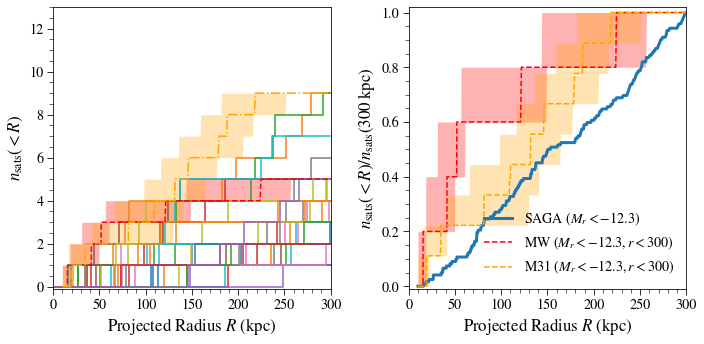

In [142]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

for host in completed_hosts:
    r_kpc = r_kpc_hosts[host['HOSTID']]
    r_kpc.sort()
    if len(r_kpc)<1:
        continue
        
    r_kpc_step, n = r_to_steps(r_kpc)
    
    #ax1.step(r_kpc_step, n, label=host['COMMON_NAME'], where='post')
    ax1.step(r_kpc_step, n, where='post')
    
ax1.plot(rbins, percs_mw_unnorm[:, 1], label='MW ($M_r < -12.3$)', c='red', ls='--')
ax1.fill_between(rbins, percs_mw_unnorm[:, 0], percs_mw_unnorm[:, 2], color='red', alpha=.3, lw=0)

ax1.plot(rbins, percs_m31_unnorm[:, 1], label='M31 ($M_r < -12.3$)', c='orange', ls='-.')
ax1.fill_between(rbins, percs_m31_unnorm[:, 0], percs_m31_unnorm[:, 2], color='orange', alpha=.3, lw=0)

    
ax1.set_xlabel(r'Projected Radius $R$ (kpc)')
ax1.set_ylabel(r'$n_{\rm sats}(<R)$')
#ax1.legend(loc=0)
ax1.set_ylim(-0.1, 13)



ax2.plot(rbins, n_in_rbin/np.max(n_in_rbin), label='SAGA ($M_r < -12.3$)', lw=3,)
# ax2.plot(rbins, n_in_rbin_lmc/np.max(n_in_rbin_lmc), label='SAGA (w/LMC)', lw=2, ls='--')
# ax2.plot(rbins, n_in_rbin_nlmc/np.max(n_in_rbin_nlmc), label='SAGA (no LMC)', lw=2, ls='-.')
ax2.plot(rbins, percs_mw_norm[:, 1], label='MW ($M_r < -12.3, r < 300$)', c='red', ls='--')
ax2.fill_between(rbins, percs_mw_norm[:, 0], percs_mw_norm[:, 2], color='red', alpha=.3, lw=0)
ax2.plot(rbins, percs_m31_norm[:, 1], label='M31 ($M_r < -12.3, r < 300$)', c='orange', ls='--')
ax2.fill_between(rbins, percs_m31_norm[:, 0], percs_m31_norm[:, 2], color='orange', alpha=.3, lw=0)

ax2.set_xlabel(r'Projected Radius $R$ (kpc)')
ax2.set_ylabel(r'$n_{\rm sats}(<R)/n_{\rm sats}(300 \;{\rm kpc})$')
ax2.legend(loc='lower right')
ax2.set_ylim(-0.01, 1.02)

for ax in (ax1, ax2):
    #ax.axvline(300.0, c='k', ls=':', lw=0.5)
    #ax2.set_xlim(0, rbins[-1])
    ax.set_xlim(0, 300)

fig.tight_layout()

fig.savefig('radial_dist_within.pdf')

## No "within" cut

In [117]:
#MW 
mcconn_mw = mcconn_tab_saga_observable#[(mcconn_tab_saga_observable['distance'] < 300)]
mwprojs_shrunk = project_mc(SkyCoord(mcconn_mw['center']), 1000)

percs_mw_unnorm = get_rbin_percs(mwprojs_shrunk, rbins*u.kpc, None)
percs_mw_norm = get_rbin_percs(mwprojs_shrunk, rbins*u.kpc, 300*u.kpc)

In [118]:
#M31 
m31dist = m31coo.separation_3d(SkyCoord(mcconn_tab_saga_observable['center']))
mcconn_m31 = mcconn_tab_saga_observable#[m31dist<300*u.kpc]
m31projs_shrunk = project_mc(SkyCoord(mcconn_m31['center']), 400, center=m31coo)

percs_m31_unnorm = get_rbin_percs(m31projs_shrunk, rbins*u.kpc, None)
percs_m31_norm = get_rbin_percs(m31projs_shrunk, rbins*u.kpc, 300*u.kpc)

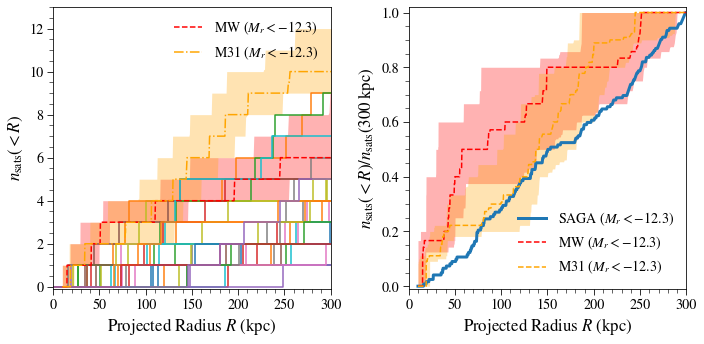

In [120]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

for host in completed_hosts:
    r_kpc = r_kpc_hosts[host['HOSTID']]
    r_kpc.sort()
    if len(r_kpc)<1:
        continue
        
    r_kpc_step, n = r_to_steps(r_kpc)
    
    #ax1.step(r_kpc_step, n, label=host['COMMON_NAME'], where='post')
    ax1.step(r_kpc_step, n, where='post')
    
ax1.plot(rbins, percs_mw_unnorm[:, 1], label='MW ($M_r < -12.3$)', c='red', ls='--')
ax1.fill_between(rbins, percs_mw_unnorm[:, 0], percs_mw_unnorm[:, 2], color='red', alpha=.3, lw=0)

ax1.plot(rbins, percs_m31_unnorm[:, 1], label='M31 ($M_r < -12.3$)', c='orange', ls='-.')
ax1.fill_between(rbins, percs_m31_unnorm[:, 0], percs_m31_unnorm[:, 2], color='orange', alpha=.3, lw=0)

    
ax1.set_xlabel(r'Projected Radius $R$ (kpc)')
ax1.set_ylabel(r'$n_{\rm sats}(<R)$')
#ax1.legend(loc=0)
ax1.set_ylim(-0.1, 13)



ax2.plot(rbins, n_in_rbin/np.max(n_in_rbin), label='SAGA ($M_r < -12.3$)', lw=3,)
# ax2.plot(rbins, n_in_rbin_lmc/np.max(n_in_rbin_lmc), label='SAGA (w/LMC)', lw=2, ls='--')
# ax2.plot(rbins, n_in_rbin_nlmc/np.max(n_in_rbin_nlmc), label='SAGA (no LMC)', lw=2, ls='-.')
ax2.plot(rbins, percs_mw_norm[:, 1], label='MW ($M_r < -12.3$)', c='red', ls='--')
ax2.fill_between(rbins, percs_mw_norm[:, 0], percs_mw_norm[:, 2], color='red', alpha=.3, lw=0)
ax2.plot(rbins, percs_m31_norm[:, 1], label='M31 ($M_r < -12.3$)', c='orange', ls='--')
ax2.fill_between(rbins, percs_m31_norm[:, 0], percs_m31_norm[:, 2], color='orange', alpha=.3, lw=0)

ax2.set_xlabel(r'Projected Radius $R$ (kpc)')
ax2.set_ylabel(r'$n_{\rm sats}(<R)/n_{\rm sats}(300 \;{\rm kpc})$')
ax2.legend(loc=0)
ax2.set_ylim(-0.01, 1.02)

for ax in (ax1, ax2):
    #ax.axvline(300.0, c='k', ls=':', lw=0.5)
    #ax2.set_xlim(0, rbins[-1])
    ax.set_xlim(0, 300)

fig.tight_layout()

fig.savefig('radial_dist_nowithin.pdf')

### Does LMC-or-not have any information? 

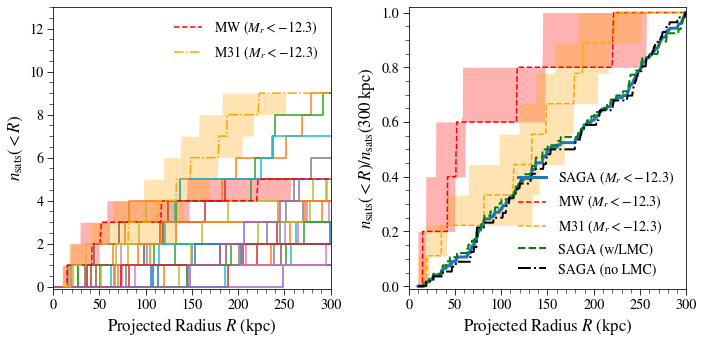

In [94]:
ax2.plot(rbins, n_in_rbin_lmc/np.max(n_in_rbin_lmc), label='SAGA (w/LMC)', lw=2, ls='--', c='g')
ax2.plot(rbins, n_in_rbin_nlmc/np.max(n_in_rbin_nlmc), label='SAGA (no LMC)', lw=2, ls='-.', c='k')
ax2.legend(loc=0)

fig

Not really

## Only Bright ones

In [133]:
#build per-host radial distributions
r_kpc_hosts_bright = {}
for hostid in observed_hosts['HOSTID']:
    sat_qry_bright = (Query('Mr < -15') & QueryMaker.equals('HOSTID', hostid))
    r_kpc_hosts_bright[hostid] = np.array(sat_qry_bright.filter(sats_completed_hosts, 'RHOST_KPC'), dtype=float)*u.kpc

In [134]:
n_in_rbin_bright = binr(rbins, Query('Mr < -15').filter(sats_completed_hosts, 'RHOST_KPC'))

In [125]:
#MW 
mcconn_mw = mcconn_tab_saga_observable[(mcconn_tab_saga_observable['rabs'] < -15)]
mwprojs_shrunk = project_mc(SkyCoord(mcconn_mw['center']), 1000)

percs_mw_unnorm = get_rbin_percs(mwprojs_shrunk, rbins*u.kpc, None)
percs_mw_norm = get_rbin_percs(mwprojs_shrunk, rbins*u.kpc, 300*u.kpc)

In [129]:
#M31 
m31dist = m31coo.separation_3d(SkyCoord(mcconn_tab_saga_observable['center']))
mcconn_m31 = mcconn_tab_saga_observable[mcconn_tab_saga_observable['rabs'] < -15]
m31projs_shrunk = project_mc(SkyCoord(mcconn_m31['center']), 400, center=m31coo)

percs_m31_unnorm = get_rbin_percs(m31projs_shrunk, rbins*u.kpc, None)
percs_m31_norm = get_rbin_percs(m31projs_shrunk, rbins*u.kpc, 300*u.kpc)

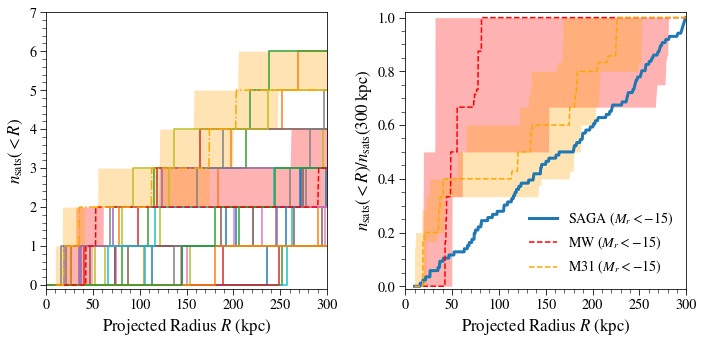

In [136]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

for host in completed_hosts:
    r_kpc = r_kpc_hosts_bright[host['HOSTID']]
    r_kpc.sort()
    if len(r_kpc)<1:
        continue
        
    r_kpc_step, n = r_to_steps(r_kpc)
    
    #ax1.step(r_kpc_step, n, label=host['COMMON_NAME'], where='post')
    ax1.step(r_kpc_step, n, where='post')
    
ax1.plot(rbins, percs_mw_unnorm[:, 1], label='MW ($M_r < -12.3$)', c='red', ls='--')
ax1.fill_between(rbins, percs_mw_unnorm[:, 0], percs_mw_unnorm[:, 2], color='red', alpha=.3, lw=0)

ax1.plot(rbins, percs_m31_unnorm[:, 1], label='M31 ($M_r < -12.3$)', c='orange', ls='-.')
ax1.fill_between(rbins, percs_m31_unnorm[:, 0], percs_m31_unnorm[:, 2], color='orange', alpha=.3, lw=0)

    
ax1.set_xlabel(r'Projected Radius $R$ (kpc)')
ax1.set_ylabel(r'$n_{\rm sats}(<R)$')
#ax1.legend(loc=0)
ax1.set_ylim(-0.1, 7)



ax2.plot(rbins, n_in_rbin_bright/np.max(n_in_rbin_bright), label='SAGA ($M_r < -15$)', lw=3,)
ax2.plot(rbins, percs_mw_norm[:, 1], label='MW ($M_r < -15$)', c='red', ls='--')
ax2.fill_between(rbins, percs_mw_norm[:, 0], percs_mw_norm[:, 2], color='red', alpha=.3, lw=0)
ax2.plot(rbins, percs_m31_norm[:, 1], label='M31 ($M_r < -15$)', c='orange', ls='--')
ax2.fill_between(rbins, percs_m31_norm[:, 0], percs_m31_norm[:, 2], color='orange', alpha=.3, lw=0)

ax2.set_xlabel(r'Projected Radius $R$ (kpc)')
ax2.set_ylabel(r'$n_{\rm sats}(<R)/n_{\rm sats}(300 \;{\rm kpc})$')
ax2.legend(loc=0)
ax2.set_ylim(-0.01, 1.02)

for ax in (ax1, ax2):
    #ax.axvline(300.0, c='k', ls=':', lw=0.5)
    #ax2.set_xlim(0, rbins[-1])
    ax.set_xlim(0, 300)

fig.tight_layout()

fig.savefig('radial_dist_nowithin_bright.pdf')

In [137]:
pwd

'/home/erik/projects/saga/erik'

In [139]:
!explorer.exe .